In [11]:
# ============================
# 1. INSTALL & IMPORT LIBRARIES
# ============================
# Import all necessary libraries for data manipulation, visualization, model training, and evaluation.
# ucimlrepo is used to automatically fetch the dataset from the UCI repository.
# Warnings are suppressed to keep output clean.

# !pip install ucimlrepo  # Run once if needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer

from ucimlrepo import fetch_ucirepo

import warnings
warnings.filterwarnings('ignore')


First 5 rows of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Clump_thickness              699 non-null    int64  
 1   Uniformity_of_cell_size      699 non-null    int64  
 2   Uniformity_of_cell_shape     699 non-null    int64  
 3   Marginal_adhesion            699 non-null    int64  
 4   Single_epithelial_cell_size  699 non-null    int64  
 5   Bare_nuclei                  683 non-null    float64
 6   Bland_chromatin              699 non-null    int64  
 7   Normal_nucleoli              699 non-null    int64  
 8   Mitoses                      699 non-null    int64  
 9   Target                       699 non-null    int64  
dtypes: float64(1), int64(9)
memory usage: 54.7 KB
None
   Clump_thickness  Uniformity_of_cell_size  Uniformity_of_cell_shape  \
0                5                       

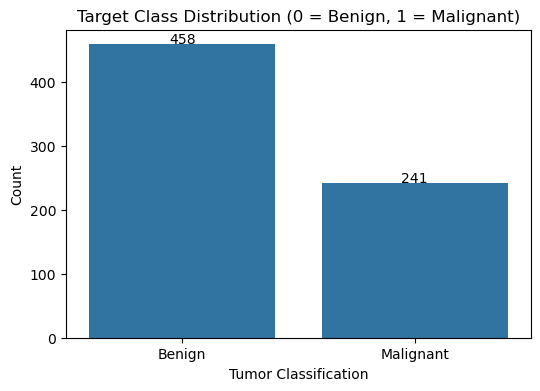

Top 5 features most correlated with Target:
Uniformity_of_cell_shape    0.818934
Uniformity_of_cell_size     0.817904
Bare_nuclei                 0.816050
Bland_chromatin             0.756616
Clump_thickness             0.716001
dtype: float64


In [13]:
# ============================
# 2. LOAD DATA FROM UCI
# ============================
# Fetch the Breast Cancer Wisconsin dataset directly from UCI repository.
# Display basic dataset info and a sample of the first few rows.

print("First 5 rows of the dataset:")
# Dataset ID 15: Breast Cancer Wisconsin (Original)
dataset = fetch_ucirepo(id=15)

# Combine features and targets into a single DataFrame for easier manipulation
data = pd.concat([dataset.data.features, dataset.data.targets], axis=1)
data.rename(columns={'Class': 'Target'}, inplace=True)
# Map class labels: 2 = benign -> 0, 4 = malignant -> 1
data['Target'] = data['Target'].map({2: 0, 4: 1})

# Show structure and contents of the dataset
print(data.info())
print(data.head())
print("Descriptive statistics:")
print(data.describe())

# Visualize distribution of class labels
plt.figure(figsize=(6,4))
sns.countplot(x='Target', data=data)
plt.xlabel('Tumor Classification')
plt.xticks([0, 1], ['Benign', 'Malignant'])
for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width() / 2., p.get_height() + 1,
             int(p.get_height()), ha='center')
plt.ylabel('Count')
plt.title('Target Class Distribution (0 = Benign, 1 = Malignant)')
plt.show()

# Highlight top correlated features with the target
correlations = X_imputed.corrwith(y).abs().sort_values(ascending=False)
top_features = correlations.head(5)
print("Top 5 features most correlated with Target:")
print(top_features)
plt.show()



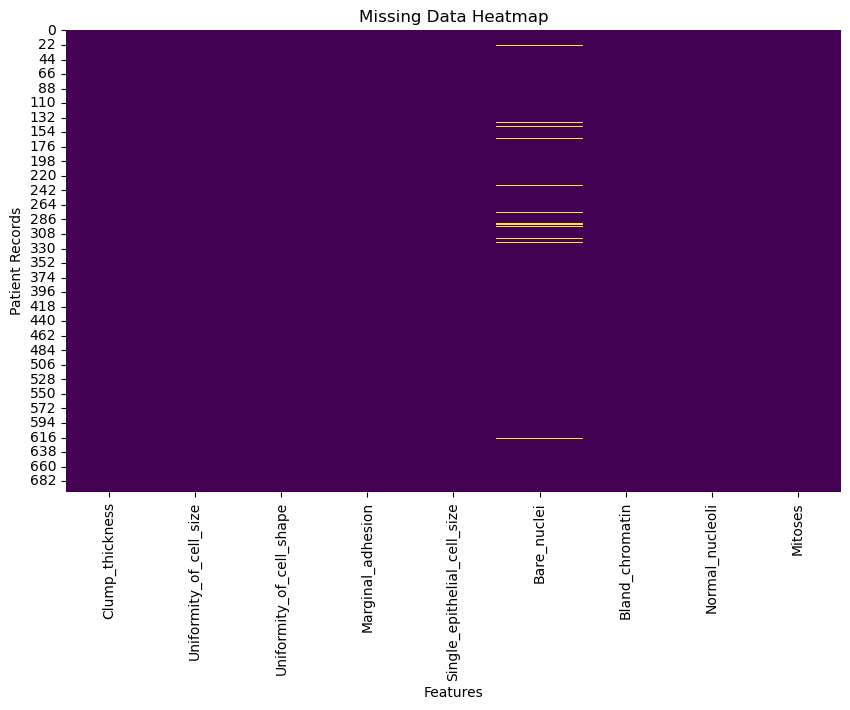

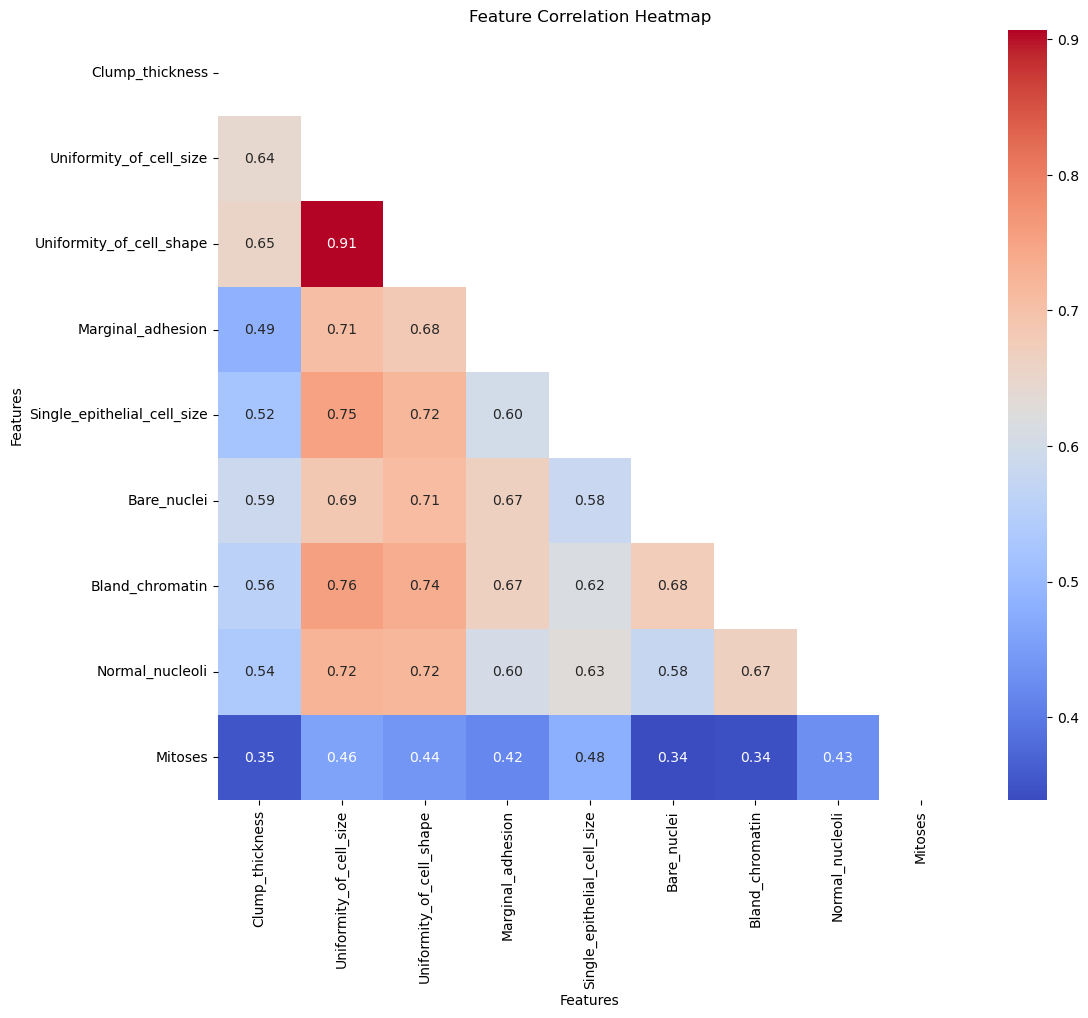

Top 5 features most correlated with Target:
Uniformity_of_cell_shape    0.818934
Uniformity_of_cell_size     0.817904
Bare_nuclei                 0.816050
Bland_chromatin             0.756616
Clump_thickness             0.716001
dtype: float64


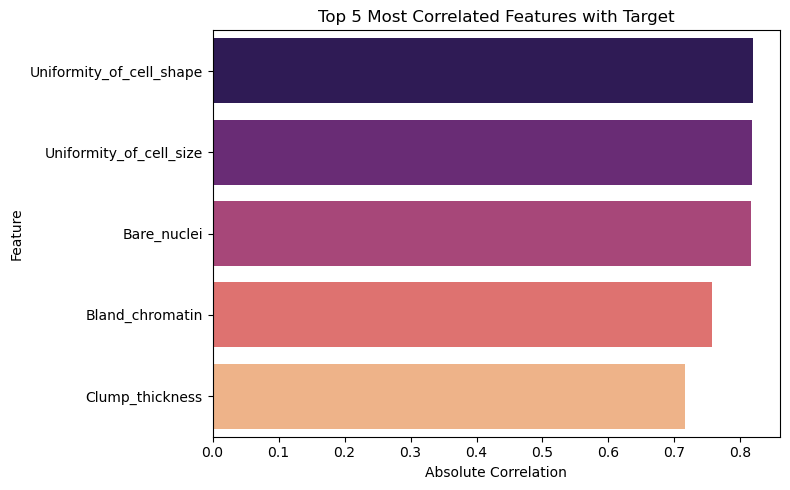

In [15]:
# ============================
# 3. EXPLORE, CLEAN & PREPARE FEATURES
# ============================
# Separate the features and target variable
X = data.drop('Target', axis=1)
y = data['Target']

# Visualize any missing values across features
plt.figure(figsize=(10,6))
sns.heatmap(X.isnull(), cbar=False, cmap='viridis')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Patient Records')
plt.title('Missing Data Heatmap')
plt.show()

# Impute missing values using mean strategy
# This replaces NaNs with the mean of each column
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Ensure no missing values remain in the target column
y = y[y.notna()]
X_imputed = X_imputed.loc[y.index]  # Align indexes post-drop

# Display correlation matrix of features
# Highlight and annotate features with high correlation to the target (if applicable)
plt.figure(figsize=(12, 10))
corr_matrix = X_imputed.corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f', mask=mask)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Feature Correlation Heatmap')
plt.show()

# Highlight top correlated features with the target
correlations = X_imputed.corrwith(y).abs().sort_values(ascending=False)
top_features = correlations.head(5)
print("Top 5 features most correlated with Target:")
print(top_features)

# Visualize top correlated features with a bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=top_features.values, y=top_features.index, palette='magma')
plt.title('Top 5 Most Correlated Features with Target')
plt.xlabel('Absolute Correlation')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.25, random_state=42)


In [17]:
# ============================
# 4. MODEL TRAINING & EVALUATION FUNCTION
# ============================
# Define a function to train a model, evaluate it, and display key metrics and visualizations

def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", cm)
    print(classification_report(y_test, y_pred))

    # Display the confusion matrix as a heatmap
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.show()

    # Plot predicted vs. actual comparison
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.xlabel("Actual Labels")
    plt.ylabel("Predicted Labels")
    plt.title(f"{name} - Actual vs. Predicted Labels")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return name, acc, cm



=== Decision Tree ===
Accuracy: 0.9371
Confusion Matrix:
 [[115   3]
 [  8  49]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       118
           1       0.94      0.86      0.90        57

    accuracy                           0.94       175
   macro avg       0.94      0.92      0.93       175
weighted avg       0.94      0.94      0.94       175



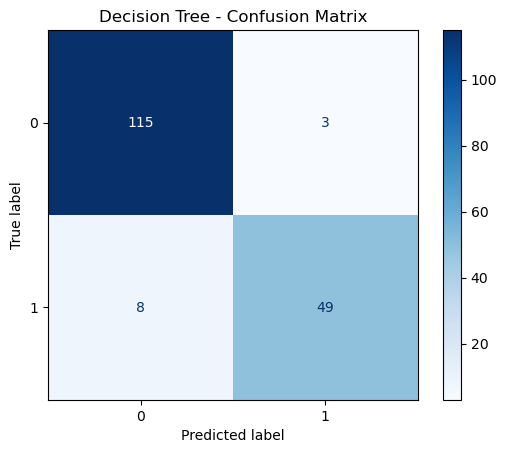

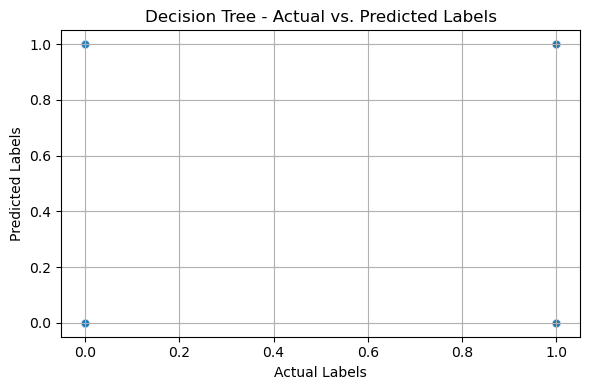

Summary of Decision Tree Model Performance:
           Model  Accuracy     Confusion Matrix
0  Decision Tree  0.937143  [[115, 3], [8, 49]]


In [19]:
# ============================
# 5. DECISION TREE CLASSIFIER
# ============================
# Apply Decision Tree to classify tumor types as benign or malignant
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42)
evaluate_model(dt_model, "Decision Tree")

# ============================
# 6. MODEL PERFORMANCE SUMMARY FOR DECISION TREE
# ============================
# Collect model name, accuracy, and confusion matrix into a summary DataFrame for documentation
# This is useful for comparing multiple models later.

dt_results = {
    'Model': ['Decision Tree'],
    'Accuracy': [accuracy_score(y_test, dt_model.predict(X_test))],
    'Confusion Matrix': [confusion_matrix(y_test, dt_model.predict(X_test))]
}

results_df = pd.DataFrame(dt_results)
print("Summary of Decision Tree Model Performance:")
print(results_df)

# Optional: Save results to CSV
# results_df.to_csv("decision_tree_results_summary.csv", index=False)
